Project01_NN

In [ ]:
#Task 2: Read the MNIST dataset
import gzip
import pickle

filename = 'mnist.pkl.gz'

try:
    # Open the gzipped file in binary mode
    with gzip.open(filename, 'rb') as f:
        # Load the data directly using pickle
        training_data, validation_data, test_data = pickle.load(f, encoding='latin1')

    # Print a success message and the data shapes to confirm loading
    print("Data loaded successfully!")
    print(f"Training data shape: {training_data[0].shape}")
    print(f"Validation data shape: {validation_data[0].shape}")
    print(f"Test data shape: {test_data[0].shape}")

except FileNotFoundError:
    print(f"Error: The file '{filename}' was not found. Please make sure it's in the correct directory.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

Data loaded successfully!
Training data shape: (50000, 784)
Validation data shape: (10000, 784)
Test data shape: (10000, 784)


=== Gradient Check ===
=== Feedforward Neural Network Demo ===
Solving XOR problem...
Network architecture: 2 -> 4 -> 1
Training...
Epoch 100/2000, Loss: 0.125167
Epoch 200/2000, Loss: 0.125099
Epoch 300/2000, Loss: 0.125050
Epoch 400/2000, Loss: 0.125012
Epoch 500/2000, Loss: 0.124980
Epoch 600/2000, Loss: 0.124949
Epoch 700/2000, Loss: 0.124915
Epoch 800/2000, Loss: 0.124873
Epoch 900/2000, Loss: 0.124817
Epoch 1000/2000, Loss: 0.124731
Epoch 1100/2000, Loss: 0.124590
Epoch 1200/2000, Loss: 0.124335
Epoch 1300/2000, Loss: 0.123842
Epoch 1400/2000, Loss: 0.122848
Epoch 1500/2000, Loss: 0.120887
Epoch 1600/2000, Loss: 0.117329
Epoch 1700/2000, Loss: 0.111565
Epoch 1800/2000, Loss: 0.103510
Epoch 1900/2000, Loss: 0.094015
Epoch 2000/2000, Loss: 0.083563

=== Testing Results ===
Input: [0 0] | Expected: 0 | Predicted: 0.2595
Input: [0 1] | Expected: 1 | Predicted: 0.6156
Input: [1 0] | Expected: 1 | Predicted: 0.6091
Input: [1 1] | Expected: 0 | Predicted: 0.5475

Accuracy: 75.00%


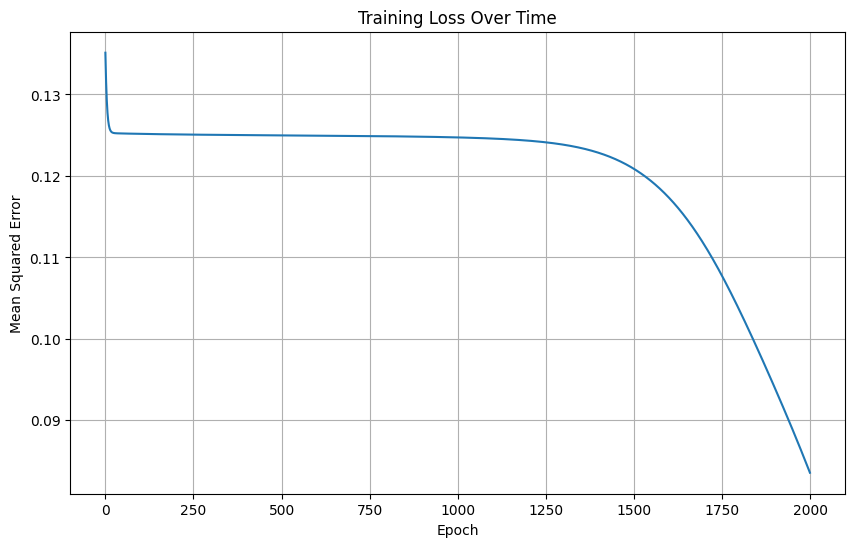


=== Network Parameters ===
Weights W1 (Input -> Hidden):
[[-3.28537157  1.00881351 -0.62774266 -0.61611751]
 [-3.29586875 -0.3615951  -0.96507794 -0.4656347 ]]

Biases b1 (Hidden layer):
[[ 0.47473714  0.36864159  0.61904046 -0.03975084]]

Weights W2 (Hidden -> Output):
[[-3.53748217]
 [-0.59056121]
 [ 1.97819586]
 [ 0.43488697]]

Biases b2 (Output layer):
[[-0.01731294]]


In [8]:
# Task 1&4: Implement a feedforward neural network with backpropagation in SGD
import numpy as np
import matplotlib.pyplot as plt

class FeedforwardNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        """
        Initialize the feedforward neural network with 3 layers.
        
        Args:
            input_size (int): Number of neurons in input layer
            hidden_size (int): Number of neurons in hidden layer
            output_size (int): Number of neurons in output layer
            learning_rate (float): Learning rate for training
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # Initialize weights randomly with small values
        # Weights between input and hidden layer
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.5
        # Weights between hidden and output layer
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.5
        
        # Initialize biases
        self.b1 = np.zeros((1, self.hidden_size))
        self.b2 = np.zeros((1, self.output_size))
        
        # Store activations for backpropagation
        self.z1 = None  # Hidden layer input (before activation)
        self.a1 = None  # Hidden layer output (after activation)
        self.z2 = None  # Output layer input (before activation)
        self.a2 = None  # Output layer output (after activation)
    
    def sigmoid(self, x):
        """
        Sigmoid activation function.
        
        Args:
            x (numpy.ndarray): Input array
            
        Returns:
            numpy.ndarray: Sigmoid of input
        """
        # Clip x to prevent overflow
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        """
        Derivative of sigmoid function.
        
        Args:
            x (numpy.ndarray): Input array (output of sigmoid)
            
        Returns:
            numpy.ndarray: Derivative of sigmoid
        """
        return x * (1 - x)
    
    def forward(self, X):
        """
        Forward propagation through the network.
        
        Args:
            X (numpy.ndarray): Input data of shape (samples, features)
            
        Returns:
            numpy.ndarray: Output predictions
        """
        # Input to hidden layer
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        
        # Hidden to output layer
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        
        return self.a2
    

    # ===== Project01_NN · Task 4: backpropagation algorithm =====
    def backprop(self, X, y, output):
        """
        Compute gradients for a mini-batch and RETURN them (do NOT update parameters).
        Shapes follow your current convention.
        """
        m = X.shape[0]

        # output_error = a - y
        output_error = output - y                                # (m, output_size)
        output_delta = output_error * self.sigmoid_derivative(output)   # (m, output_size)

        dW2 = self.a1.T.dot(output_delta) / m                   # (hidden_size, output_size)
        db2 = np.sum(output_delta, axis=0, keepdims=True) / m   # (1, output_size)

        hidden_error = output_delta.dot(self.W2.T)              # (m, hidden_size)
        hidden_delta = hidden_error * self.sigmoid_derivative(self.a1)  # (m, hidden_size)

        dW1 = X.T.dot(hidden_delta) / m                         # (input_size, hidden_size)
        db1 = np.sum(hidden_delta, axis=0, keepdims=True) / m   # (1, hidden_size)

        dx = hidden_delta.dot(self.W1.T)  # (m, input_size)


        return dW1, db1, dW2, db2, dx


    def train(self, X, y, epochs=1000, verbose=True):
        """
        Train the neural network using backpropagation.
        
        Args:
            X (numpy.ndarray): Training input data
            y (numpy.ndarray): Training labels
            epochs (int): Number of training epochs
            verbose (bool): Whether to print training progress
            
        Returns:
            list: Training loss history
        """
        loss_history = []
        
        for epoch in range(epochs):
            # Forward propagation
            output = self.forward(X)
            
            # Calculate loss (Mean Squared Error)
            # loss = np.mean((output - y) ** 2)
            loss = 0.5 * np.mean(np.sum((output - y) ** 2, axis=1))
            loss_history.append(loss)
            
            # Backward propagation
            dW1, db1, dW2, db2, dx = self.backprop(X, y, output)
            self.W2 -= self.learning_rate * dW2
            self.b2 -= self.learning_rate * db2
            self.W1 -= self.learning_rate * dW1
            self.b1 -= self.learning_rate * db1

            
            # Print progress
            if verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.6f}")
        
        return loss_history    

    def predict(self, X):
        """
        Make predictions on new data.
        
        Args:
            X (numpy.ndarray): Input data
            
        Returns:
            numpy.ndarray: Predictions
        """
        return self.forward(X)
        
    def get_parameters(self):
        """
        Get current network parameters.
        
        Returns:
            dict: Dictionary containing weights and biases
        """
        return {
            'W1': self.W1,
            'b1': self.b1,
            'W2': self.W2,
            'b2': self.b2
        }
    
    def set_parameters(self, params):
        """
        Set network parameters.
        
        Args:
            params (dict): Dictionary containing weights and biases
        """
        self.W1 = params['W1']
        self.b1 = params['b1']
        self.W2 = params['W2']
        self.b2 = params['b2']

def gradient_check(nn, X, y, epsilon=1e-5, tolerance=1e-6):
    """
    Compare backprop gradients with numerical gradients (finite differences).
    """
    output = nn.forward(X)
    dW1, db1, dW2, db2, dx = nn.backprop(X, y, output)

def loss_fn():
    out = nn.forward(X)
    return 0.5 * np.mean(np.sum((out - y) ** 2, axis=1))


    print("Checking W1...")
    for i in range(nn.W1.shape[0]):
        for j in range(nn.W1.shape[1]):
            orig = nn.W1[i, j]
            nn.W1[i, j] = orig + epsilon
            loss_plus = loss_fn()
            nn.W1[i, j] = orig - epsilon
            loss_minus = loss_fn()
            nn.W1[i, j] = orig  # reset
            num_grad = (loss_plus - loss_minus) / (2 * epsilon)
            rel_error = abs(num_grad - dW1[i, j]) / (abs(num_grad) + abs(dW1[i, j]) + 1e-12)
            if rel_error > tolerance:
                print(f"  Gradient check failed at W1[{i},{j}]: "
                      f"num={num_grad:.6e}, backprop={dW1[i,j]:.6e}, rel_error={rel_error:.2e}")
                return False

    print("W1 passed gradient check!")
    return True


#below is a simple test for training, you need change according to your corresponding tasks
if __name__ == "__main__":
    print("=== Gradient Check ===")
    nn_test = FeedforwardNeuralNetwork(input_size=2, hidden_size=2, output_size=1, learning_rate=0.1)
    X_small = np.array([[0, 1],
                        [1, 0]])
    y_small = np.array([[1],
                        [1]])

    gradient_check(nn_test, X_small, y_small)
    # Generate sample data for XOR problem
    print("=== Feedforward Neural Network Demo ===")
    print("Solving XOR problem...")
    
    # XOR dataset
    X = np.array([[0, 0],
                  [0, 1],
                  [1, 0],
                  [1, 1]])
    
    y = np.array([[0],
                  [1],
                  [1],
                  [0]])
    
    # Create and train the neural network
    nn = FeedforwardNeuralNetwork(input_size=2, hidden_size=4, output_size=1, learning_rate=1.0)
    
    print(f"Network architecture: {nn.input_size} -> {nn.hidden_size} -> {nn.output_size}")
    print("Training...")
    
    # Train the network
    loss_history = nn.train(X, y, epochs=2000, verbose=True)
    
    # Test the trained network
    print("\n=== Testing Results ===")
    predictions = nn.predict(X)
    
    for i in range(len(X)):
        print(f"Input: {X[i]} | Expected: {y[i][0]} | Predicted: {predictions[i][0]:.4f}")
    
    # Calculate accuracy (for binary classification)
    binary_predictions = (predictions > 0.5).astype(int)
    accuracy = np.mean(binary_predictions == y)
    print(f"\nAccuracy: {accuracy * 100:.2f}%")
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    plt.show()
    
    # Display network parameters
    print("\n=== Network Parameters ===")
    params = nn.get_parameters()
    print("Weights W1 (Input -> Hidden):")
    print(params['W1'])
    print("\nBiases b1 (Hidden layer):")
    print(params['b1'])
    print("\nWeights W2 (Hidden -> Output):")
    print(params['W2'])
    print("\nBiases b2 (Output layer):")
    print(params['b2'])

In [3]:
# ===== Project01_NN · Task 3: Mini-batch SGD training =====
class FeedforwardNeuralNetwork_SGD(FeedforwardNeuralNetwork):
    """
    Extend the original network with mini-batch SGD training.
    """
    def train_sgd(self, X, y, epochs=10, batch_size=32, shuffle=True, verbose=True):
        n = X.shape[0]
        loss_history = []

        for epoch in range(1, epochs + 1):
            # shuffle data at the beginning of each epoch
            if shuffle:
                perm = np.random.permutation(n)
                X_epoch = X[perm]
                y_epoch = y[perm]
            else:
                X_epoch = X
                y_epoch = y

            total_loss = 0.0
            # iterate over mini-batches
            for start in range(0, n, batch_size):
                end = min(start + batch_size, n)
                xb = X_epoch[start:end]
                yb = y_epoch[start:end]

                out = self.forward(xb)
                # batch_loss = np.mean((out - yb) ** 2)
                batch_loss = 0.5 * np.mean(np.sum((out - yb) ** 2, axis=1))
                total_loss += batch_loss * (end - start)

                # update parameters using backpropagation
                dW1, db1, dW2, db2, dx = self.backprop(xb, yb, out)
                self.W2 -= self.learning_rate * dW2
                self.b2 -= self.learning_rate * db2
                self.W1 -= self.learning_rate * dW1
                self.b1 -= self.learning_rate * db1


            epoch_loss = total_loss / n
            loss_history.append(epoch_loss)
            if verbose:
                print(f"Epoch {epoch}/{epochs} | batch_size={batch_size} | MSE: {epoch_loss:.6f}")

        return loss_history


# Example usage with XOR dataset:
# nn_sgd = FeedforwardNeuralNetwork_SGD(input_size=2, hidden_size=4, output_size=1, learning_rate=1.0)
# loss_hist = nn_sgd.train_sgd(X, y, epochs=2000, batch_size=2, verbose=True)
# 
# pred = nn_sgd.predict(X)
# print(pred)

Loading MNIST data...
=== MNIST Training ===
Architecture: 784 -> 30 -> 10
Epochs: 50, Batch size: 10, Learning rate: 0.2
------------------------------------------------------------
Epoch  1/50 | Train Loss: 0.1349 | Train Acc: 84.72% | Val Acc: 86.52%
Epoch  2/50 | Train Loss: 0.0977 | Train Acc: 88.64% | Val Acc: 90.21%
Epoch  3/50 | Train Loss: 0.0831 | Train Acc: 90.47% | Val Acc: 91.46%
Epoch  4/50 | Train Loss: 0.0746 | Train Acc: 91.22% | Val Acc: 92.17%
Epoch  5/50 | Train Loss: 0.0683 | Train Acc: 91.93% | Val Acc: 92.70%
Epoch  6/50 | Train Loss: 0.0638 | Train Acc: 92.54% | Val Acc: 93.08%
Epoch  7/50 | Train Loss: 0.0599 | Train Acc: 93.07% | Val Acc: 93.31%
Epoch  8/50 | Train Loss: 0.0574 | Train Acc: 93.31% | Val Acc: 93.55%
Epoch  9/50 | Train Loss: 0.0549 | Train Acc: 93.54% | Val Acc: 93.83%
Epoch 10/50 | Train Loss: 0.0529 | Train Acc: 93.81% | Val Acc: 93.92%
Epoch 11/50 | Train Loss: 0.0515 | Train Acc: 94.02% | Val Acc: 94.00%
Epoch 12/50 | Train Loss: 0.0498 | T

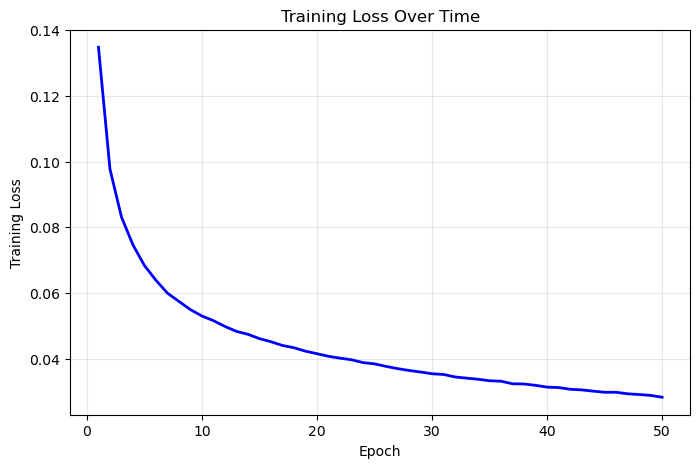


Final Test Results: Loss: 0.0395, Accuracy: 95.50%


In [4]:
# Tasks 5 & 6: MNIST Training
import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt

def load_mnist_data(filename='mnist.pkl.gz'):
    with gzip.open(filename, 'rb') as f:
        training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    return training_data, validation_data, test_data

def vectorize_target(target, num_classes=10):
    vector = np.zeros((num_classes, 1))
    vector[target] = 1.0
    return vector

def prepare_mnist_data(training_data, validation_data, test_data):
    # Training data
    train_X = np.array([x.reshape(-1, 1) for x in training_data[0]])
    train_X = train_X.reshape(len(train_X), -1)  # (50000, 784)
    train_y = np.array([vectorize_target(y).reshape(-1, 1) for y in training_data[1]])
    train_y = train_y.reshape(len(train_y), -1)  # (50000, 10)
    
    # Validation data
    val_X = np.array([x.reshape(-1, 1) for x in validation_data[0]])
    val_X = val_X.reshape(len(val_X), -1)
    val_y = np.array([vectorize_target(y).reshape(-1, 1) for y in validation_data[1]])
    val_y = val_y.reshape(len(val_y), -1)
    
    # Test data
    test_X = np.array([x.reshape(-1, 1) for x in test_data[0]])
    test_X = test_X.reshape(len(test_X), -1)
    test_y = np.array([vectorize_target(y).reshape(-1, 1) for y in test_data[1]])
    test_y = test_y.reshape(len(test_y), -1)
    
    return train_X, train_y, val_X, val_y, test_X, test_y

def calculate_accuracy(predictions, targets):
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(targets, axis=1)
    return np.mean(predicted_classes == true_classes) * 100

def train_mnist_network(network, train_X, train_y, val_X, val_y, epochs=30, batch_size=10):
    print("=== MNIST Training ===")
    print(f"Architecture: {network.input_size} -> {network.hidden_size} -> {network.output_size}")
    print(f"Epochs: {epochs}, Batch size: {batch_size}, Learning rate: {network.learning_rate}")
    print("-" * 60)
    
    # Store training loss for plotting
    epochs_list = []
    train_losses = []
    
    for epoch in range(1, epochs + 1):
        # Train one epoch
        network.train_sgd(train_X, train_y, epochs=1, batch_size=batch_size, shuffle=True, verbose=False)
        
        # Evaluate performance
        train_pred = network.predict(train_X[:50000])  
        train_loss = 0.5 * np.mean(np.sum((train_pred - train_y[:50000]) ** 2, axis=1))
        train_acc = calculate_accuracy(train_pred, train_y[:50000])
        
        val_pred = network.predict(val_X)
        val_loss = 0.5 * np.mean(np.sum((val_pred - val_y) ** 2, axis=1))
        val_acc = calculate_accuracy(val_pred, val_y)
        
        epochs_list.append(epoch)
        train_losses.append(train_loss)
        
        # Task 6: Print learning success per epoch
        print(f"Epoch {epoch:2d}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:5.2f}% | Val Acc: {val_acc:5.2f}%")
    
    print("-" * 60)
    
    # Plot training loss
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_list, train_losses, 'b-', linewidth=2)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return network

if __name__ == "__main__":
    print("Loading MNIST data...")
    training_data, validation_data, test_data = load_mnist_data('mnist.pkl.gz')
    train_X, train_y, val_X, val_y, test_X, test_y = prepare_mnist_data(training_data, validation_data, test_data)
    
    # Task 5
    nn_mnist = FeedforwardNeuralNetwork_SGD(input_size=784, hidden_size=30, output_size=10, learning_rate=0.2)
    trained_network = train_mnist_network(nn_mnist, train_X, train_y, val_X, val_y, epochs=50, batch_size=10)
    
    # Test final performance
    test_pred = trained_network.predict(test_X)
    test_loss = 0.5 * np.mean(np.sum((test_pred - test_y) ** 2, axis=1))
    test_acc = calculate_accuracy(test_pred, test_y)
    print(f"\nFinal Test Results: Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")

In [5]:
# Tasks 7: Attack
def fgsm_attack(network, X, y, epsilon=0.1):
    output = network.forward(X)
    _, _, _, _, grad_input = network.backprop(X, y, output)

    perturbation = epsilon * np.sign(grad_input)
    X_adv = np.clip(X + perturbation, 0, 1)
    return X_adv

True label: 7, Original prediction: 7
Adversarial prediction: 7
⚠️ Attack failed


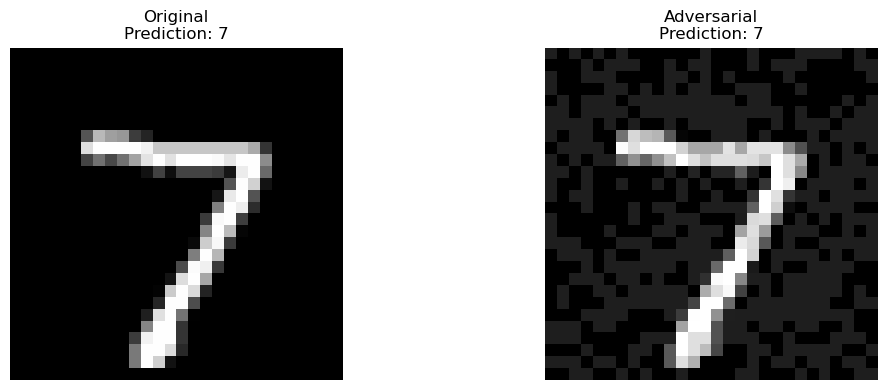

In [6]:
# ===== Attack Test =====
import numpy as np
import matplotlib.pyplot as plt

train_data, val_data, test_data = load_mnist_data('mnist.pkl.gz')
train_X, train_y, val_X, val_y, test_X, test_y = prepare_mnist_data(train_data, val_data, test_data)

if 'trained_network' not in globals():
    network = FeedforwardNeuralNetwork_SGD(input_size=784, hidden_size=30, output_size=10, learning_rate=0.2)
    trained_network = train_mnist_network(network, train_X, train_y, val_X, val_y, epochs=10, batch_size=10)
else:
    trained_network = globals()['trained_network']

X_sample, y_sample = test_X[0:1], test_y[0:1]
true_label = np.argmax(y_sample)
pred_orig = np.argmax(trained_network.forward(X_sample))
print(f"True label: {true_label}, Original prediction: {pred_orig}")

# Generate adversarial sample
epsilon = 0.12
X_adv = fgsm_attack(trained_network, X_sample, y_sample, epsilon=epsilon)
pred_adv = np.argmax(trained_network.forward(X_adv))
print(f"Adversarial prediction: {pred_adv}")
print("✅ Attack Success!" if pred_adv != pred_orig else "⚠️ Attack failed")

# Visualize
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(X_sample.reshape(28,28), cmap='gray')
plt.title(f'Original\nPrediction: {pred_orig}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(X_adv.reshape(28,28), cmap='gray')
plt.title(f'Adversarial\nPrediction: {pred_adv}')
plt.axis('off')

plt.tight_layout()
plt.show()


Project 1a

=== Multi-Layer Feedforward Neural Network MNIST Demo ===

=== Quick XOR Test ===
XOR Test - Accuracy: 50.00%

=== MNIST Dataset ===
Loading MNIST data...
Training data shape: (50000, 784), (50000, 10)
Validation data shape: (10000, 784), (10000, 10)
Test data shape: (10000, 784), (10000, 10)

=== Test 3: Single Hidden Layer Network ===
=== MNIST Training ===
Network Architecture: 784 -> 30 -> 10
Total layers: 3
Hidden layers: 1
Layer 1: 784 -> 30 (23550 parameters)
Layer 2: 30 -> 10 (310 parameters)
Total parameters: 23860
Epochs: 20, Batch size: 10, Learning rate: 0.2
--------------------------------------------------------------------------------
Epoch  1/20 | Train Loss: 0.1255 | Train Acc: 87.81% | Val Acc: 88.91%
Epoch  2/20 | Train Loss: 0.0802 | Train Acc: 91.01% | Val Acc: 91.85%
Epoch  3/20 | Train Loss: 0.0676 | Train Acc: 92.31% | Val Acc: 92.86%
Epoch  4/20 | Train Loss: 0.0606 | Train Acc: 93.05% | Val Acc: 93.51%
Epoch  5/20 | Train Loss: 0.0558 | Train Acc: 93.47% | Val

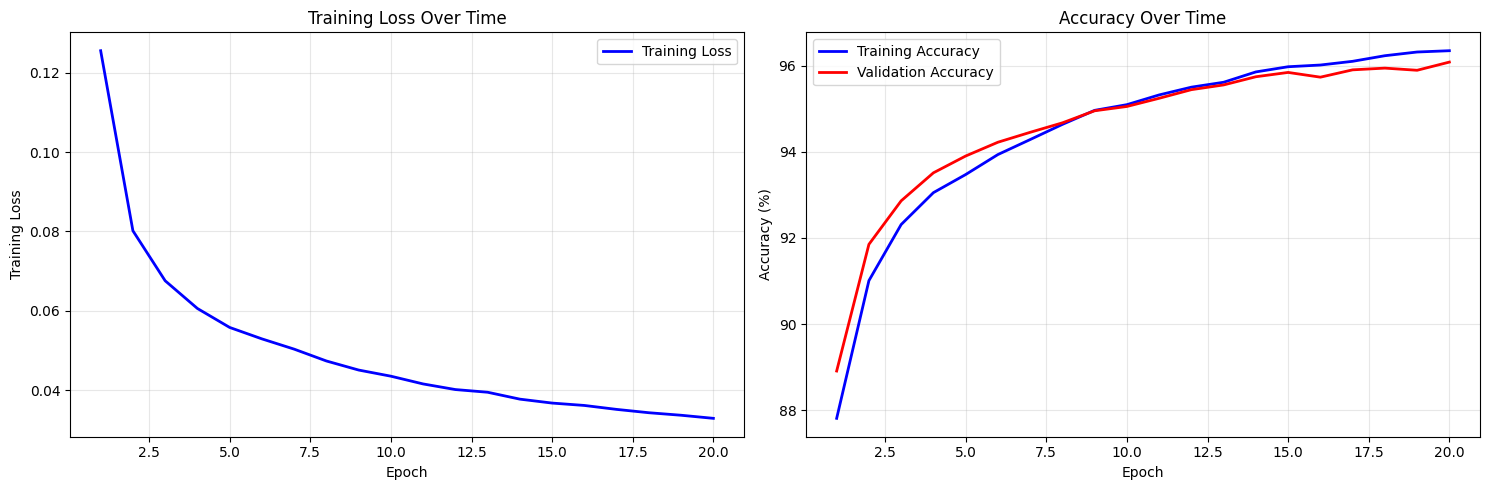

Single Layer - Final Test Results: Loss: 0.0377, Accuracy: 95.46%

=== Test 4: Multi-Layer Network Comparison ===
=== MNIST Training ===
Network Architecture: 784 -> 128 -> 64 -> 10
Total layers: 4
Hidden layers: 2
Layer 1: 784 -> 128 (100480 parameters)
Layer 2: 128 -> 64 (8256 parameters)
Layer 3: 64 -> 10 (650 parameters)
Total parameters: 109386
Epochs: 20, Batch size: 10, Learning rate: 0.1
--------------------------------------------------------------------------------
Epoch  1/20 | Train Loss: 0.4500 | Train Acc: 11.36% | Val Acc: 10.64%
Epoch  2/20 | Train Loss: 0.4502 | Train Acc: 11.36% | Val Acc: 10.64%
Epoch  3/20 | Train Loss: 0.4500 | Train Acc: 11.36% | Val Acc: 10.64%
Epoch  4/20 | Train Loss: 0.4501 | Train Acc:  9.98% | Val Acc:  9.61%
Epoch  5/20 | Train Loss: 0.4498 | Train Acc: 11.36% | Val Acc: 10.64%
Epoch  6/20 | Train Loss: 0.4495 | Train Acc: 11.85% | Val Acc: 10.91%
Epoch  7/20 | Train Loss: 0.3847 | Train Acc: 27.38% | Val Acc: 27.22%
Epoch  8/20 | Train Los

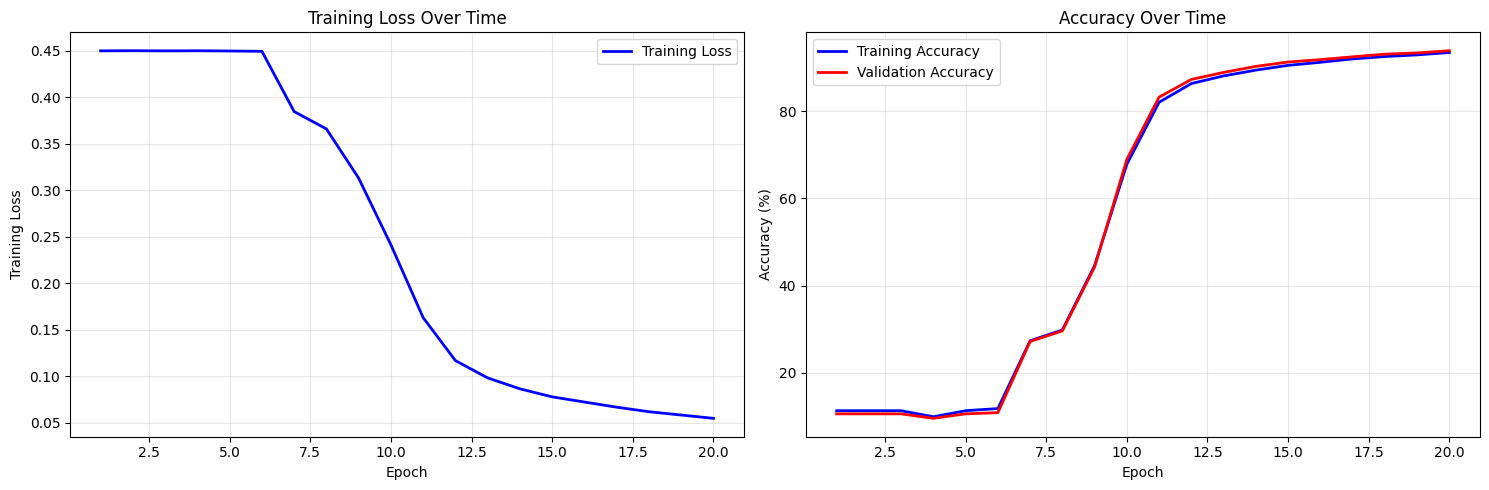

Multi-Layer - Final Test Results: Loss: 0.0546, Accuracy: 93.19%

=== Visualizing Predictions ===


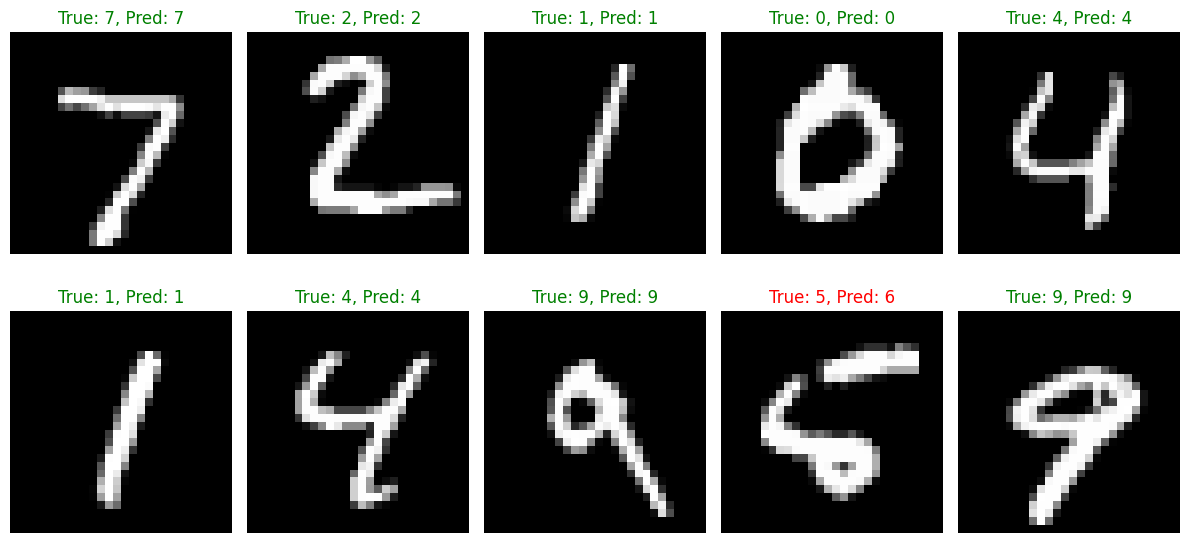


=== Final Comparison Summary ===
Single Layer [784->30->10]:     Test Accuracy: 95.46%
Multi-Layer [784->128->64->10]: Test Accuracy: 93.19%

Test 6: === Gradient Check ===
Performing gradient check...
Checking layer 1 weights...
  Gradient check failed at W0[1,1]: num=2.380623e-07, backprop=2.380611e-07, rel_error=2.68e-06


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import gzip

#task 1: Feedforward neural network with any number of layers and any number of neurons in each layer
class FeedforwardNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01):
        """
        Initialize the feedforward neural network with any number of layers.
        
        Args:
            layer_sizes (list): List of integers specifying the number of neurons in each layer.
                               First element is input size, last element is output size.

            learning_rate (float): Learning rate for training
        """
        if len(layer_sizes) < 2:
            raise ValueError("Network must have at least input and output layers (minimum 2 layers)")
        
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.learning_rate = learning_rate
        
        # Initialize weights and biases for each layer connection
        self.weights = []
        self.biases = []
        
        # Create weights and biases between consecutive layers
        for i in range(self.num_layers - 1):
            # Xavier/He initialization for better convergence
            # weight = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2.0 / layer_sizes[i])

            # initialization with small values
            weight = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01
            bias = np.zeros((1, layer_sizes[i + 1]))
            
            self.weights.append(weight)
            self.biases.append(bias)
        
        # Storage for forward propagation (needed for backpropagation)
        self.activations = []  # Store activations for each layer
        self.z_values = []     # Store pre-activation values for each layer
    
    def sigmoid(self, x):
        """
        Sigmoid activation function with numerical stability.
        
        Args:
            x (numpy.ndarray): Input array
            
        Returns:
            numpy.ndarray: Sigmoid of input
        """
        # Clip x to prevent overflow
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, sigmoid_output):
        """
        Derivative of sigmoid function.
        
        Args:
            sigmoid_output (numpy.ndarray): Output of sigmoid function
            
        Returns:
            numpy.ndarray: Derivative of sigmoid
        """
        return sigmoid_output * (1 - sigmoid_output)
    
    def forward(self, X):
        """
        Forward propagation through the network.
        
        Args:
            X (numpy.ndarray): Input data of shape (samples, input_features)
            
        Returns:
            numpy.ndarray: Output predictions
        """
        # Clear previous forward pass data
        self.activations = [X]  # First activation is the input
        self.z_values = []
        
        current_input = X
        
        # Propagate through each layer
        for i in range(self.num_layers - 1):
            # Linear transformation: z = X * W + b
            z = np.dot(current_input, self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            
            # Apply activation function
            a = self.sigmoid(z)
            self.activations.append(a)
            
            # Output of current layer becomes input to next layer
            current_input = a
        
        return self.activations[-1]  # Return final output
    
    def backprop(self, X, y, output):
        """
        Compute gradients using backpropagation for multi-layer network.
        
        Args:
            X (numpy.ndarray): Input data
            y (numpy.ndarray): True labels
            output (numpy.ndarray): Network output from forward pass
            
        Returns:
            tuple: Lists of weight gradients and bias gradients
        """
        m = X.shape[0]  # Number of samples
        
        # Initialize gradient storage
        dW = [None] * (self.num_layers - 1)
        db = [None] * (self.num_layers - 1)
        
        # Start with output layer error
        delta = (output - y) * self.sigmoid_derivative(output)
        
        # Backpropagate through each layer (from output to input)
        for i in reversed(range(self.num_layers - 1)):
            # Compute gradients for current layer
            dW[i] = np.dot(self.activations[i].T, delta) / m
            db[i] = np.sum(delta, axis=0, keepdims=True) / m
            
            # Compute error for previous layer (if not at input layer)
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(self.activations[i])
        
        return dW, db
    
    def train(self, X, y, epochs=1000, verbose=True):
        """
        Train the neural network using full batch gradient descent.
        
        Args:
            X (numpy.ndarray): Training input data
            y (numpy.ndarray): Training labels
            epochs (int): Number of training epochs
            verbose (bool): Whether to print training progress
            
        Returns:
            list: Training loss history
        """
        loss_history = []
        
        for epoch in range(epochs):
            # Forward propagation
            output = self.forward(X)
            
            # Calculate loss (Mean Squared Error)
            loss = 0.5 * np.mean(np.sum((output - y) ** 2, axis=1))
            loss_history.append(loss)
            
            # Backward propagation
            dW, db = self.backprop(X, y, output)
            
            # Update parameters
            for i in range(self.num_layers - 1):
                self.weights[i] -= self.learning_rate * dW[i]
                self.biases[i] -= self.learning_rate * db[i]
            
            # Print progress
            if verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.6f}")
        
        return loss_history
    
    def train_sgd(self, X, y, epochs=1000, batch_size=32, shuffle=True, verbose=True):
        """
        Train the neural network using stochastic gradient descent (mini-batch).
        
        Args:
            X (numpy.ndarray): Training input data
            y (numpy.ndarray): Training labels
            epochs (int): Number of training epochs
            batch_size (int): Size of mini-batches
            shuffle (bool): Whether to shuffle data each epoch
            verbose (bool): Whether to print training progress
            
        Returns:
            list: Training loss history
        """
        loss_history = []
        n_samples = X.shape[0]
        
        for epoch in range(epochs):
            # Shuffle data if requested
            if shuffle:
                indices = np.random.permutation(n_samples)
                X_shuffled = X[indices]
                y_shuffled = y[indices]
            else:
                X_shuffled = X
                y_shuffled = y
            
            epoch_loss = 0
            num_batches = 0
            
            # Process mini-batches
            for start_idx in range(0, n_samples, batch_size):
                end_idx = min(start_idx + batch_size, n_samples)
                batch_X = X_shuffled[start_idx:end_idx]
                batch_y = y_shuffled[start_idx:end_idx]
                
                # Forward propagation
                output = self.forward(batch_X)
                
                # Calculate batch loss
                batch_loss = 0.5 * np.mean(np.sum((output - batch_y) ** 2, axis=1))
                epoch_loss += batch_loss
                num_batches += 1
                
                # Backward propagation
                dW, db = self.backprop(batch_X, batch_y, output)
                
                # Update parameters
                for i in range(self.num_layers - 1):
                    self.weights[i] -= self.learning_rate * dW[i]
                    self.biases[i] -= self.learning_rate * db[i]
            
            # Average loss for this epoch
            avg_loss = epoch_loss / num_batches
            loss_history.append(avg_loss)
            
            # Print progress
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, batch_size={batch_size}, Average Loss: {avg_loss:.6f}")
        
        return loss_history
    
    def predict(self, X):
        """
        Make predictions on new data.
        
        Args:
            X (numpy.ndarray): Input data
            
        Returns:
            numpy.ndarray: Predictions
        """
        return self.forward(X)
    
    def get_parameters(self):
        """
        Get current network parameters.
        
        Returns:
            dict: Dictionary containing weights and biases
        """
        return {
            'weights': self.weights.copy(),
            'biases': self.biases.copy(),
            'layer_sizes': self.layer_sizes
        }
    
    def set_parameters(self, params):
        """
        Set network parameters.
        
        Args:
            params (dict): Dictionary containing weights and biases
        """
        self.weights = params['weights']
        self.biases = params['biases']
        self.layer_sizes = params['layer_sizes']
        self.num_layers = len(self.layer_sizes)
    
    def print_architecture(self):
        """Print network architecture information."""
        print(f"Network Architecture: {' -> '.join(map(str, self.layer_sizes))}")
        print(f"Total layers: {self.num_layers}")
        print(f"Hidden layers: {self.num_layers - 2}")
        
        total_params = 0
        for i in range(len(self.weights)):
            layer_params = self.weights[i].size + self.biases[i].size
            total_params += layer_params
            print(f"Layer {i+1}: {self.layer_sizes[i]} -> {self.layer_sizes[i+1]} "
                  f"({layer_params} parameters)")
        
        print(f"Total parameters: {total_params}")

# MNIST Data Loading and Processing Functions
def load_mnist_data(filename='mnist.pkl.gz'):
    """Load MNIST dataset from pickle file."""
    with gzip.open(filename, 'rb') as f:
        training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    return training_data, validation_data, test_data

def vectorize_target(target, num_classes=10):
    """Convert target label to one-hot vector."""
    vector = np.zeros((num_classes, 1))
    vector[target] = 1.0
    return vector

def prepare_mnist_data(training_data, validation_data, test_data):
    """Prepare MNIST data for training."""
    # Training data
    train_X = np.array([x.reshape(-1, 1) for x in training_data[0]])
    train_X = train_X.reshape(len(train_X), -1)  # (50000, 784)
    train_y = np.array([vectorize_target(y).reshape(-1, 1) for y in training_data[1]])
    train_y = train_y.reshape(len(train_y), -1)  # (50000, 10)
    
    # Validation data
    val_X = np.array([x.reshape(-1, 1) for x in validation_data[0]])
    val_X = val_X.reshape(len(val_X), -1)
    val_y = np.array([vectorize_target(y).reshape(-1, 1) for y in validation_data[1]])
    val_y = val_y.reshape(len(val_y), -1)
    
    # Test data
    test_X = np.array([x.reshape(-1, 1) for x in test_data[0]])
    test_X = test_X.reshape(len(test_X), -1)
    test_y = np.array([vectorize_target(y).reshape(-1, 1) for y in test_data[1]])
    test_y = test_y.reshape(len(test_y), -1)
    
    return train_X, train_y, val_X, val_y, test_X, test_y

def calculate_accuracy(predictions, targets):
    """Calculate classification accuracy."""
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(targets, axis=1)
    return np.mean(predicted_classes == true_classes) * 100

def train_mnist_network(network, train_X, train_y, val_X, val_y, epochs=30, batch_size=10):
    """Train network on MNIST dataset with monitoring."""
    print("=== MNIST Training ===")
    network.print_architecture()
    print(f"Epochs: {epochs}, Batch size: {batch_size}, Learning rate: {network.learning_rate}")
    print("-" * 80)
    
    # Store training metrics for plotting
    epochs_list = []
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(1, epochs + 1):
        # Train one epoch
        network.train_sgd(train_X, train_y, epochs=1, batch_size=batch_size, shuffle=True, verbose=False)
        
        # Evaluate performance
        train_pred = network.predict(train_X)
        train_loss = 0.5 * np.mean(np.sum((train_pred - train_y) ** 2, axis=1))
        train_acc = calculate_accuracy(train_pred, train_y)
        
        val_pred = network.predict(val_X)
        val_loss = 0.5 * np.mean(np.sum((val_pred - val_y) ** 2, axis=1))
        val_acc = calculate_accuracy(val_pred, val_y)
        
        # Store metrics
        epochs_list.append(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Print learning success per epoch
        print(f"Epoch {epoch:2d}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:5.2f}% | Val Acc: {val_acc:5.2f}%")
    
    print("-" * 80)
    
    # Plot training metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training loss
    ax1.plot(epochs_list, train_losses, 'b-', linewidth=2, label='Training Loss')
    ax1.set_title('Training Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot accuracies
    ax2.plot(epochs_list, train_accuracies, 'b-', linewidth=2, label='Training Accuracy')
    ax2.plot(epochs_list, val_accuracies, 'r-', linewidth=2, label='Validation Accuracy')
    ax2.set_title('Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return network

def visualize_predictions(network, test_X, test_y, num_samples=10):
    """Visualize some predictions from the network."""
    predictions = network.predict(test_X[:num_samples])
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_y[:num_samples], axis=1)
    
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        # Reshape image data back to 28x28
        image = test_X[i].reshape(28, 28)
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'True: {true_classes[i]}, Pred: {predicted_classes[i]}')
        axes[i].axis('off')
        
        # Color the title based on correctness
        if predicted_classes[i] == true_classes[i]:
            axes[i].set_title(f'True: {true_classes[i]}, Pred: {predicted_classes[i]}', color='green')
        else:
            axes[i].set_title(f'True: {true_classes[i]}, Pred: {predicted_classes[i]}', color='red')
    
    plt.tight_layout()
    plt.show()

def gradient_check(nn, X, y, epsilon=1e-5, tolerance=1e-6):
    """
    Compare backprop gradients with numerical gradients (finite differences) for multi-layer network.
    """
    def loss_fn():
        out = nn.forward(X)
        return 0.5 * np.mean(np.sum((out - y) ** 2, axis=1))
    
    output = nn.forward(X)
    dW, db = nn.backprop(X, y, output)
    
    print("Performing gradient check...")
    
    # Check gradients for each layer
    for layer_idx in range(len(nn.weights)):
        print(f"Checking layer {layer_idx + 1} weights...")
        
        # Check a few random weights (not all to save time)
        weight_shape = nn.weights[layer_idx].shape
        num_checks = min(5, weight_shape[0] * weight_shape[1])
        
        for _ in range(num_checks):
            i = np.random.randint(0, weight_shape[0])
            j = np.random.randint(0, weight_shape[1])
            
            orig = nn.weights[layer_idx][i, j]
            nn.weights[layer_idx][i, j] = orig + epsilon
            loss_plus = loss_fn()
            nn.weights[layer_idx][i, j] = orig - epsilon
            loss_minus = loss_fn()
            nn.weights[layer_idx][i, j] = orig  # reset
            
            num_grad = (loss_plus - loss_minus) / (2 * epsilon)
            backprop_grad = dW[layer_idx][i, j]
            rel_error = abs(num_grad - backprop_grad) / (abs(num_grad) + abs(backprop_grad) + 1e-12)
            
            if rel_error > tolerance:
                print(f"  Gradient check failed at W{layer_idx}[{i},{j}]: "
                      f"num={num_grad:.6e}, backprop={backprop_grad:.6e}, rel_error={rel_error:.2e}")
                return False
    
    print("All gradient checks passed!")
    return True

# Below are some example tests, you need to change them according to your tasks.

if __name__ == "__main__":
    print("=== Multi-Layer Feedforward Neural Network MNIST Demo ===")
    
    # Test 1: Quick XOR test to verify implementation
    print("\n=== Quick XOR Test ===")
    X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    y_xor = np.array([[0], [1], [1], [0]])
    
    nn_xor = FeedforwardNeuralNetwork([2, 4, 1], learning_rate=1.0)
    nn_xor.train(X_xor, y_xor, epochs=1000, verbose=False)
    
    predictions_xor = nn_xor.predict(X_xor)
    accuracy_xor = np.mean((predictions_xor > 0.5).astype(int) == y_xor)
    print(f"XOR Test - Accuracy: {accuracy_xor * 100:.2f}%")
    
    # Test 2: MNIST Training and Testing
    print("\n=== MNIST Dataset ===")
    try:
        print("Loading MNIST data...")
        training_data, validation_data, test_data = load_mnist_data('mnist.pkl.gz')
        train_X, train_y, val_X, val_y, test_X, test_y = prepare_mnist_data(training_data, validation_data, test_data)
        
        print(f"Training data shape: {train_X.shape}, {train_y.shape}")
        print(f"Validation data shape: {val_X.shape}, {val_y.shape}")
        print(f"Test data shape: {test_X.shape}, {test_y.shape}")
        
        # Test 3: Single hidden layer network
        print("\n=== Test 3: Single Hidden Layer Network ===")
        nn_single = FeedforwardNeuralNetwork([784, 30, 10], learning_rate=0.2)
        trained_single = train_mnist_network(nn_single, train_X, train_y, val_X, val_y, 
                                           epochs=20, batch_size=10)
        
        # Test final performance on single layer network
        test_pred_single = trained_single.predict(test_X)
        test_loss_single = 0.5 * np.mean(np.sum((test_pred_single - test_y) ** 2, axis=1))
        test_acc_single = calculate_accuracy(test_pred_single, test_y)
        print(f"Single Layer - Final Test Results: Loss: {test_loss_single:.4f}, Accuracy: {test_acc_single:.2f}%")
        
        # Test 4: Multi-layer network comparison
        print("\n=== Test 4: Multi-Layer Network Comparison ===")
        nn_multi = FeedforwardNeuralNetwork([784, 128, 64, 10], learning_rate=0.1)
        trained_multi = train_mnist_network(nn_multi, train_X, train_y, val_X, val_y, 
                                          epochs=20, batch_size=10)
        
        # Test final performance on multi-layer network
        test_pred_multi = trained_multi.predict(test_X)
        test_loss_multi = 0.5 * np.mean(np.sum((test_pred_multi - test_y) ** 2, axis=1))
        test_acc_multi = calculate_accuracy(test_pred_multi, test_y)
        print(f"Multi-Layer - Final Test Results: Loss: {test_loss_multi:.4f}, Accuracy: {test_acc_multi:.2f}%")
        
        
        # Visualize some predictions
        print("\n=== Visualizing Predictions ===")
        visualize_predictions(trained_single, test_X, test_y, num_samples=10)
        
        # Summary comparison
        print("\n=== Final Comparison Summary ===")
        print(f"Single Layer [784->30->10]:     Test Accuracy: {test_acc_single:.2f}%")
        print(f"Multi-Layer [784->128->64->10]: Test Accuracy: {test_acc_multi:.2f}%")
        
    except FileNotFoundError:
        print("mnist.pkl.gz not found. Please ensure the MNIST dataset file is in the current directory.")
        
    
    # Test 6: Gradient check for small example
    print("\n=== Gradient Check ===")
    nn_test = FeedforwardNeuralNetwork([2, 3, 2, 1], learning_rate=0.1)
    X_small = np.array([[0, 1], [1, 0]])
    y_small = np.array([[1], [1]])
    gradient_check(nn_test, X_small, y_small)